In [3]:
pip install pandas numpy scikit-learn matplotlib yfinance tk


Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd

# List of 10 companies (stock ticker symbols)
companies = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA', 'META', 'NFLX', 'NVDA', 'SPY', 'DIS']

# Downloading stock data for the past 5 years
def fetch_data(tickers, period='5y'):
    stock_data = {}
    for ticker in tickers:
        stock_data[ticker] = yf.download(ticker, period=period)
    return stock_data

data = fetch_data(companies)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Preprocessing for LSTM
def preprocess_data(data, company):
    company_data = data[company]
    company_data = company_data[['High']]  # We're only interested in the highest price
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    company_data_scaled = scaler.fit_transform(company_data)

    # Create time-series data (use 60 previous days to predict the next day's High price)
    time_steps = 60
    X, y = [], []
    for i in range(time_steps, len(company_data_scaled)):
        X.append(company_data_scaled[i-time_steps:i, 0])  # X is the past 60 days' prices
        y.append(company_data_scaled[i, 0])  # y is the current day's High price

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Reshape X to be 3D [samples, time_steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Example: Prepare data for Apple (AAPL)
company_data = data['AAPL']
X, y, scaler = preprocess_data(data, 'AAPL')


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM Model
def build_lstm_model(X_train):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))  # Predict the High price

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Build model for Apple (AAPL)
model = build_lstm_model(X)


/Users/nainashukla/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
from sklearn.model_selection import train_test_split

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the LSTM model
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0860
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoc

In [4]:
# Predicting the High prices using the test data
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model using Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')


NameError: name 'model' is not defined

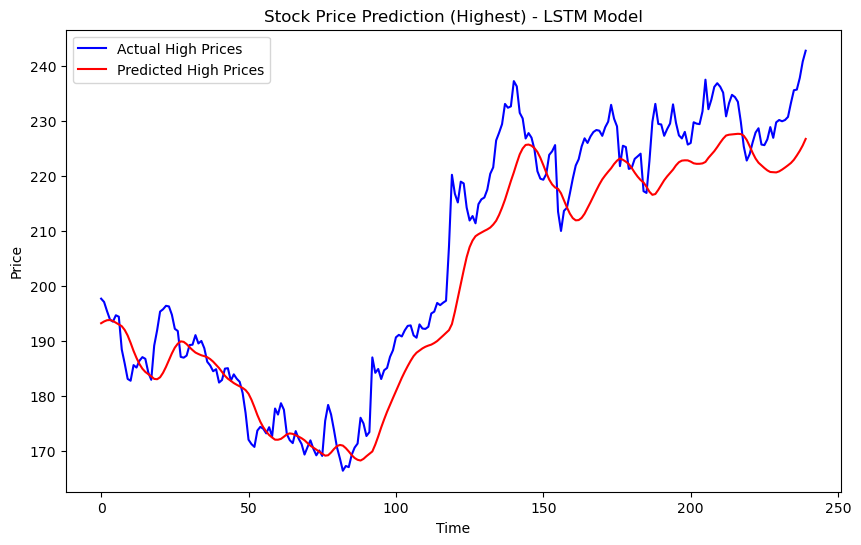

In [9]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label="Actual High Prices", color='blue')
plt.plot(y_pred_rescaled, label="Predicted High Prices", color='red')
plt.title(f"Stock Price Prediction (Highest) - LSTM Model")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [10]:
def preprocess_data_multiple_days(data, company, days_ahead=7):
    company_data = data[company]
    company_data = company_data[['High']]  # We're only interested in the highest price
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    company_data_scaled = scaler.fit_transform(company_data)

    # Create time-series data (use 60 previous days to predict the next 7 days' High prices)
    time_steps = 60
    X, y = [], []
    for i in range(time_steps, len(company_data_scaled) - days_ahead):
        X.append(company_data_scaled[i-time_steps:i, 0])  # X is the past 60 days' prices
        y.append(company_data_scaled[i:i+days_ahead, 0])  # y is the next 7 days' High prices

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Reshape X to be 3D [samples, time_steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Example: Prepare data for Apple (AAPL) for predicting the next 7 days
X, y, scaler = preprocess_data_multiple_days(data, 'AAPL', days_ahead=7)


In [11]:
import yfinance as yf

# List of company stock tickers
companies = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA', 'META', 'NFLX', 'NVDA', 'SPY', 'DIS']

# Function to fetch data for each company
def fetch_data(tickers, period='5y'):
    stock_data = {}
    for ticker in tickers:
        stock_data[ticker] = yf.download(ticker, period=period)
    return stock_data

# Fetch data for all companies
data = fetch_data(companies)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Preprocess the data for each company
def preprocess_data(data, company, time_steps=60):
    company_data = data[company]
    company_data = company_data[['High']]  # We only care about the High price

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    company_data_scaled = scaler.fit_transform(company_data)

    # Prepare data for LSTM
    X, y = [], []
    for i in range(time_steps, len(company_data_scaled)):
        X.append(company_data_scaled[i-time_steps:i, 0])  # X is the past 60 days' prices
        y.append(company_data_scaled[i, 0])  # y is the next day's High price

    X, y = np.array(X), np.array(y)
    
    # Reshape X to be [samples, time_steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Preprocess data for each company
processed_data = {}
for company in companies:
    X, y, scaler = preprocess_data(data, company)
    processed_data[company] = (X, y, scaler)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
def build_lstm_model(X_train):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))  # Predict the next day's High price

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [1]:
from tensorflow.keras.models import save_model

# Train the model for each company
for company in companies:
    # Get the preprocessed data for the current company
    X, y, scaler = processed_data[company]

    # Split data into training and test sets (80% training, 20% testing)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Build the LSTM model
    model = build_lstm_model(X_train)

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32)

    # Save the trained model
    model.save(f"{company}_lstm_model.h5")
    print(f"Model for {company} trained and saved.")


/Users/nainashukla/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


NameError: name 'companies' is not defined

In [1]:
from sklearn.metrics import mean_squared_error

# Evaluate the model for each company
for company in companies:
    # Load the saved model
    model = load_model(f"{company}_lstm_model.h5")

    # Get the preprocessed data for the current company
    X, y, scaler = processed_data[company]
    
    # Split data into training and test sets
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Predict the High prices for the test set
    y_pred = model.predict(X_test)

    # Rescale the predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    print(f"Mean Squared Error for {company}: {mse}")


NameError: name 'companies' is not defined

In [18]:
# Example: Predict the next day's High price for Apple (AAPL)
company = 'AAPL'
model = load_model(f"{company}_lstm_model.h5")

# Get the preprocessed data for the current company
X, _, scaler = processed_data[company]

# Predict the High price for the last sequence in the dataset (next day's price)
predicted_high_price = model.predict(X[-1].reshape(1, X.shape[1], X.shape[2]))

# Rescale the predicted value back to original scale
predicted_high_price_rescaled = scaler.inverse_transform(predicted_high_price)
print(f"Predicted High price for {company}: {predicted_high_price_rescaled[0][0]}")


NameError: name 'load_model' is not defined

In [19]:
from tensorflow.keras.models import load_model  # Import load_model function
from sklearn.metrics import mean_squared_error

# Evaluate the model for each company
for company in companies:
    # Load the saved model for the current company
    model = load_model(f"{company}_lstm_model.h5")

    # Get the preprocessed data for the current company
    X, y, scaler = processed_data[company]
    
    # Split data into training and test sets
    split_idx = int(0.8 * len(X))  # 80% for training, 20% for testing
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Predict the High prices for the test set
    y_pred = model.predict(X_test)

    # Rescale the predictions and actual values back to the original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    print(f"Mean Squared Error for {company}: {mse}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for AAPL: 58.530156914876244
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for GOOGL: 30.33463216422048


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for AMZN: 24.433152648859938


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Mean Squared Error for MSFT: 110.38955181315539
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error for TSLA: 239.3730588822985


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for META: 531.8736852197287
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for NFLX: 3248.289498562137
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for NVDA: 63.33801291136188
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Mean Squared Error for SPY: 125.4291050463682
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Squared Error for DIS: 10.799984427415378
